# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = ???? / CV = 
- modelo: SVM (com algumas otimizações)
- features engineering: gerado através do Auto_ViML (modificado v1)

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler



from sklearn.preprocessing import Imputer  # dealing with NaN
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm, datasets # for Support Vector Machine
from sklearn.svm import SVC

## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino_modificado.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste_modificado.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 44 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 51 colunas


In [5]:
test = test[test.columns[:-8]]

In [6]:
# Juntando os dois dataset (treino e teste)
df = train.append(test)
df.shape

(228714, 44)

In [7]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  44
Number of Categorical features:  0


## 3. Feature Engineering

In [8]:
new_df = df.copy()

In [9]:
# Create correlation matrix
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['v106', 'v91', 'v95']

In [10]:
# Drop features 
new_df = new_df.drop(new_df[to_drop], axis=1)
new_df.shape

(228714, 41)

## 4. Criar e avaliar alguns algoritmos de Machine Learning

In [11]:
# Separar o dataset de treino e teste
treino = new_df[new_df['target'].notnull()]
teste  = new_df[new_df['target'].isnull()]

# Separando features preditoras e target
#X_ = treino.drop(['ID','target'], axis=1)
X = treino.drop(['target'], axis=1)
y = treino['target']

# Padronizando os dados de treino
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 4.1. Algoritmo SVM

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [ ]:
# To Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space: C is regularization strength while gamma controls the kernel coefficient. 
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create train & test sets

# Instantiate the GridSearchCV object: cv
cv =GridSearchCV(pipeline,parameters, cv=3)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)



In [ ]:
# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Best score is: {}".format(cv.best_score_))

ConfMatrix = confusion_matrix(y_test,cv.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['B', 'M'], yticklabels = ['B', 'M'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix");

## 5. Submissions

In [29]:
# Preparando os dados de teste
new_teste = teste.drop(['target'], axis=1)
new_teste = scaler.fit_transform(new_teste)
new_teste.shape

(114393, 40)

In [32]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = modeloXGB_v2.predict_proba(new_teste)[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.320861
1,1,0.951757
2,2,0.834998
3,7,0.637067
4,10,0.689229


In [33]:
submission.to_csv('../submission/submission_xgb_v.1.0.3.csv', index=False)

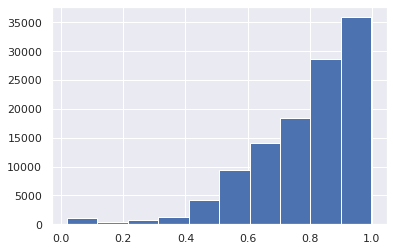

In [34]:
plt.hist(submission.PredictedProb)
plt.show()